In [1]:
import numpy
import matplotlib
from matplotlib import pyplot
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import ConnectionPatch, Rectangle
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from mpl_toolkits.mplot3d.art3d import PolyCollection
from scipy import integrate
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.text import Annotation


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)

def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)

A lot of this is copied (and updated for mpl changes) from the ICTS notebook.

In [2]:
%matplotlib inline

In [3]:
matplotlib.rcParams['font.size'] = 18

In [26]:
v = 1
t_end = 0.2
x = numpy.linspace(0, 1, 1000)
t = numpy.linspace(0, t_end, 1000)

q0 = numpy.sin(2 * numpy.pi * x)
q1_advection = numpy.sin(2 * numpy.pi * (x - v * t_end))
q1_burgers = numpy.where(x < 0.5, x, x - 1) # Not true; is it enough for illustration?
char_x_t0 = numpy.linspace(-1, 1, 41)
char_x_t1_advection = char_x_t0 + v * t_end
char_x_t1_burgers = char_x_t0 + numpy.sin(2 * numpy.pi * char_x_t0) * t_end

Text(0.5, 0, '$x$')

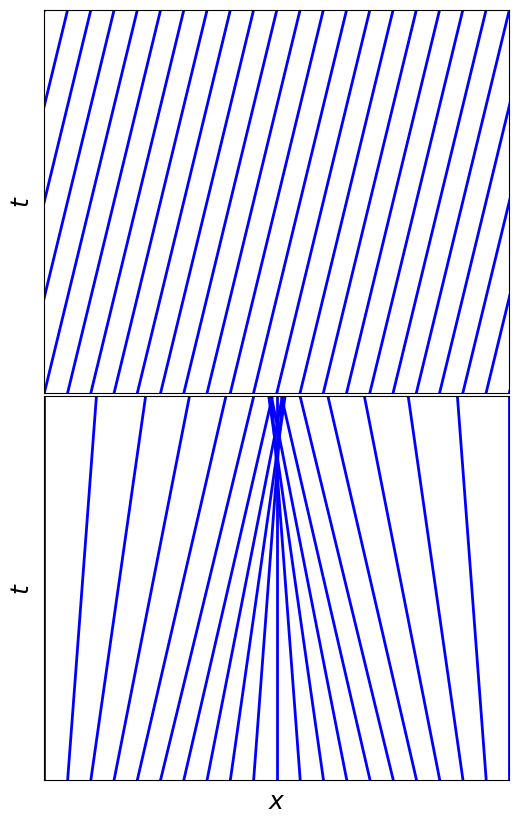

In [29]:
fig, axes = pyplot.subplots(2, 1, figsize=(6, 10), sharex=True, gridspec_kw={'hspace':0.01})
for i in range(len(char_x_t0)):
    axes[0].plot([char_x_t0[i], char_x_t1_advection[i]], [0, t_end], lw=2, color='b')
    axes[1].plot([char_x_t0[i], char_x_t1_burgers[i]], [0, t_end], lw=2, color='b')
for ax in axes:
    ax.set_ylabel(r"$t$")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, t_end)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    
axes[1].set_xlabel(r"$x$")

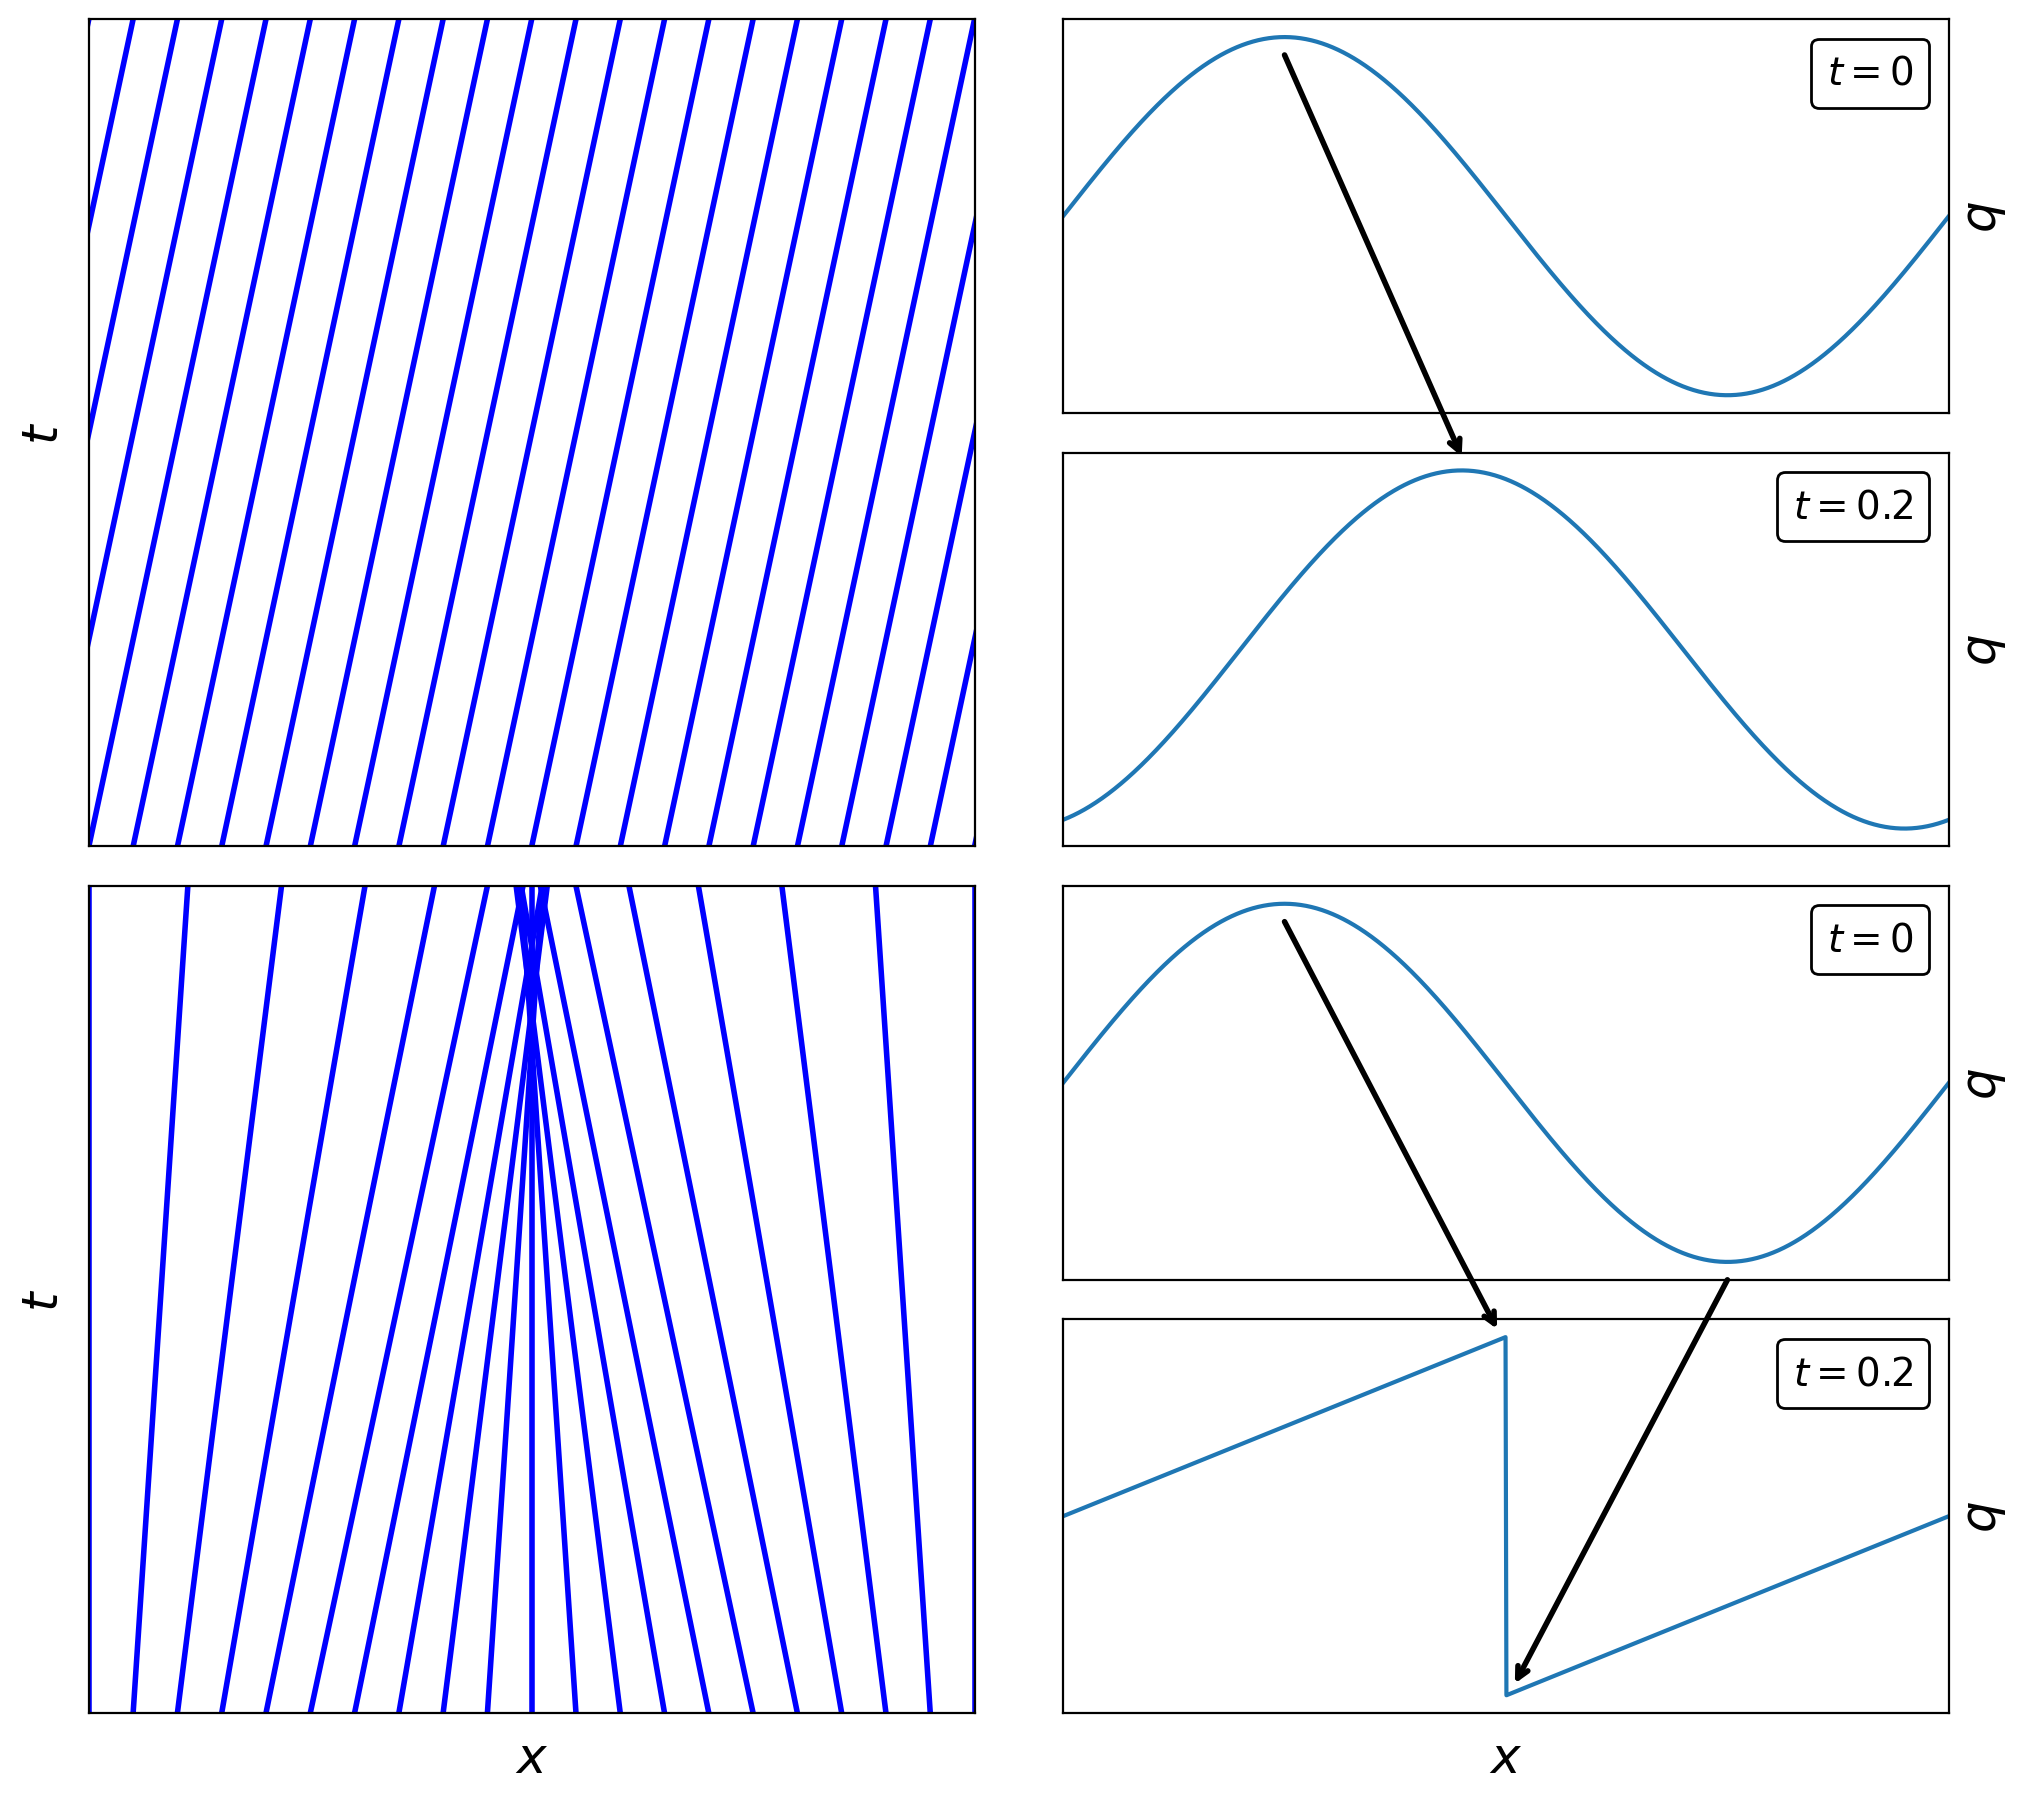

In [10]:
widths = [1, 1]
heights = [1, 1, 1, 1]
fig = pyplot.figure(constrained_layout=False, figsize=(12, 11), dpi=200)
gs = fig.add_gridspec(4, 2, width_ratios=widths, height_ratios=heights,
                      hspace=0.1, wspace=0.1)
# fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01, hspace=0.01, wspace=0.01)

ax_char = [fig.add_subplot(gs[:2, 0]), fig.add_subplot(gs[2:, 0])]
for i in range(len(char_x_t0)):
    ax_char[0].plot([char_x_t0[i], char_x_t1_advection[i]], [0, t_end], lw=2, color='b')
    ax_char[1].plot([char_x_t0[i], char_x_t1_burgers[i]], [0, t_end], lw=2, color='b')
for i, ax in enumerate(ax_char):
    if i == 1:
        ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$t$")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, t_end)
    ax.set_xticks([])
    ax.set_yticks([])

axes = []
for i in range(4):
    axes.append(fig.add_subplot(gs[i, 1]))

axes[0].plot(x, q0)
axes[1].plot(x, q1_advection)
axes[2].plot(x, q0)
axes[3].plot(x, q1_burgers)
for i, ax in enumerate(axes):
    ax.set_xlim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(r"$q$")
    ax.yaxis.set_label_position("right")
    if i == 3:
        ax.set_xlabel(r"$x$")
    if i in [0, 2]:
        at = AnchoredText(r"$t=0$",
                          prop=dict(size=14), frameon=True,
                          loc=1,
                          )
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax.add_artist(at)
    else:
        at = AnchoredText(rf"$t={t_end}$",
                          prop=dict(size=14), frameon=True,
                          loc=1,
                          )
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax.add_artist(at)
        if i==1:
            conn = ConnectionPatch(xyA=(0.45, 0.98*max(ax.get_ylim())),
                                   xyB=(0.25, 0.9),
                                   coordsA='data', coordsB='data',
                                   axesA=ax, axesB=axes[i-1],
                                   arrowstyle='<-', lw=2)
            ax.add_artist(conn)
        else:
            conn = ConnectionPatch(xyA=(0.49, 0.95*max(ax.get_ylim())),
                                   xyB=(0.25, 0.9),
                                   coordsA='data', coordsB='data',
                                   axesA=ax, axesB=axes[i-1],
                                   arrowstyle='<-', lw=2)
            ax.add_artist(conn)
            conn = ConnectionPatch(xyA=(0.51, 0.85*min(ax.get_ylim())),
                                   xyB=(0.75, -1.1),
                                   coordsA='data', coordsB='data',
                                   axesA=ax, axesB=axes[i-1],
                                   arrowstyle='<-', lw=2)
            ax.add_artist(conn)
pyplot.savefig("characteristics.svg", bbox_inches="tight")

## Riemann problems and HLL

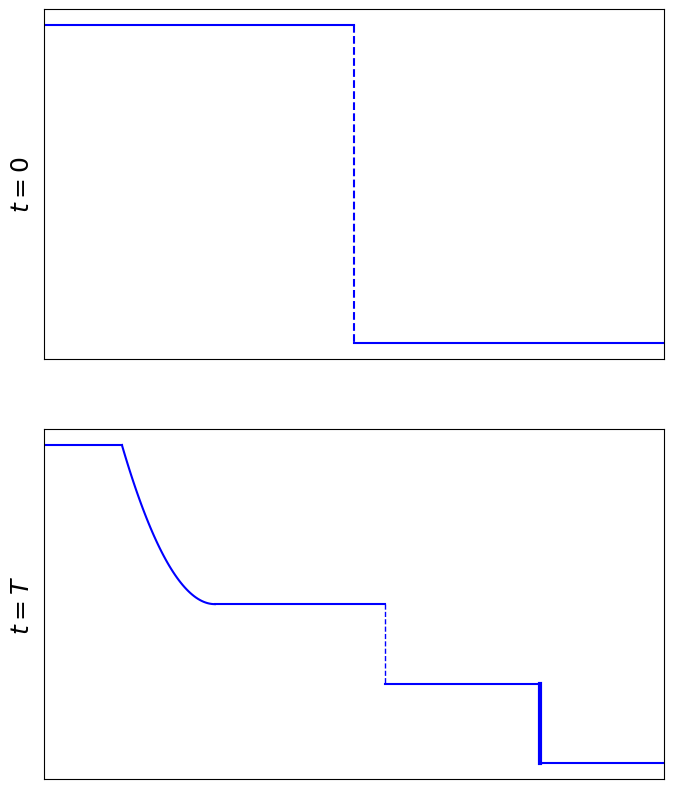

In [44]:
fig, axes = pyplot.subplots(2, 1, figsize=(8,10), sharex=True)
x = numpy.array([-1, 0, 0, 1.0])
ql = 3
qr = 1.0
qcl = 2
qcr = 1.5
q = numpy.array([ql, ql, qr, qr])
axes[0].plot(x[:2], q[:2], 'b-')
axes[0].plot(x[1:3], q[1:3], 'b--')
axes[0].plot(x[2:], q[2:], 'b-')
axes[0].set_ylabel(r'$t=0$')

wave_l_x = [-0.75, -0.45]
wave_c_x = 0.1
wave_r_x = 0.6

raref_x = numpy.linspace(wave_l_x[0], wave_l_x[1])
raref_y = (raref_x-wave_l_x[1])**2/(wave_l_x[0]-wave_l_x[1])**2+2
            
axes[1].plot([x[0], wave_l_x[0]], [ql, ql], 'b-')
axes[1].plot(raref_x, raref_y, 'b-')
axes[1].plot([wave_l_x[1], wave_c_x], [qcl, qcl], 'b-')
axes[1].plot([wave_c_x, wave_r_x], [qcr, qcr], 'b-')
axes[1].plot([wave_r_x, x[-1]], [qr, qr], 'b-')
axes[1].plot([wave_c_x, wave_c_x], [qcl, qcr], 'b--', lw=1)
axes[1].plot([wave_r_x, wave_r_x], [qcr, qr], 'b-', lw=3)
axes[1].set_ylabel(r'$t=T$')

for ax in axes.flatten():
    ax.set_xlim(-1, 1)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    
# fig.savefig('RP1.svg', bbox_inches='tight')

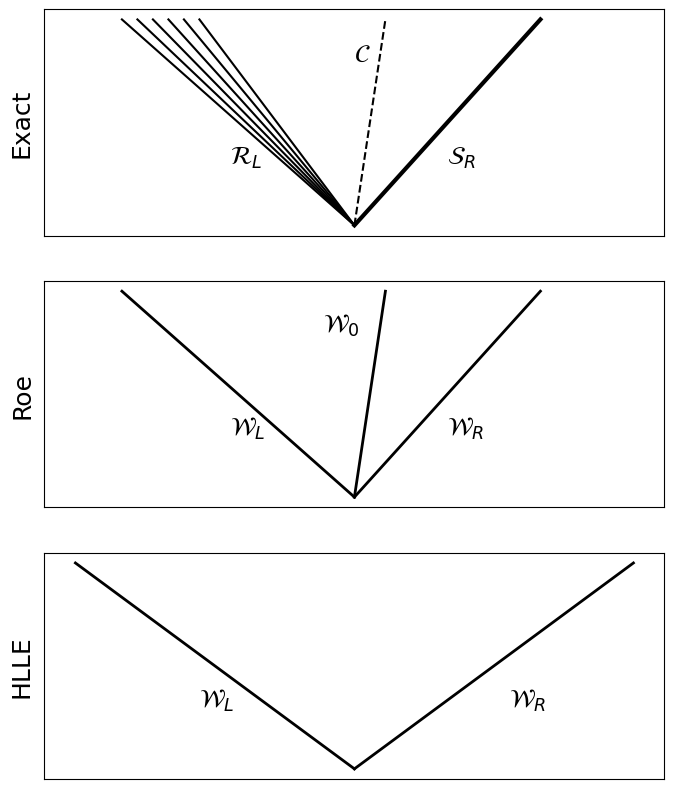

In [45]:
fig, axes = pyplot.subplots(3, 1, figsize=(8,10), sharex=True)

dx = wave_l_x[1] - wave_l_x[0]
ndx = 6
for i in range(ndx):
    axes[0].plot([0, wave_l_x[0]+i*dx/ndx], [0, 1], 'k-')
axes[0].plot([0, wave_c_x], [0, 1], 'k--')
axes[0].plot([0, wave_r_x], [0, 1], 'k-', lw=3)
axes[0].set_ylabel('Exact')
axes[0].text(-0.4, 0.3, r"$\mathcal{R}_{L}$")
axes[0].text(0, 0.8, r"$\mathcal{C}$")
axes[0].text(0.3, 0.3, r"$\mathcal{S}_{R}$")

axes[1].plot([0, wave_l_x[0]], [0, 1], 'k-', lw=2)
axes[1].plot([0, wave_c_x], [0, 1], 'k-', lw=2)
axes[1].plot([0, wave_r_x], [0, 1], 'k-', lw=2)
axes[1].set_ylabel('Roe')
axes[1].text(-0.4, 0.3, r"$\mathcal{W}_{L}$")
axes[1].text(-0.1, 0.8, r"$\mathcal{W}_0$")
axes[1].text(0.3, 0.3, r"$\mathcal{W}_{R}$")

axes[2].plot([0, -0.9], [0, 1], 'k-', lw=2)
axes[2].plot([0, 0.9], [0, 1], 'k-', lw=2)
axes[2].set_ylabel('HLLE')
axes[2].text(-0.5, 0.3, r"$\mathcal{W}_{L}$")
axes[2].text(0.5, 0.3, r"$\mathcal{W}_{R}$")

for ax in axes.flatten():
    ax.set_xlim(-1, 1)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    
# fig.savefig('RP2.svg', bbox_inches='tight')

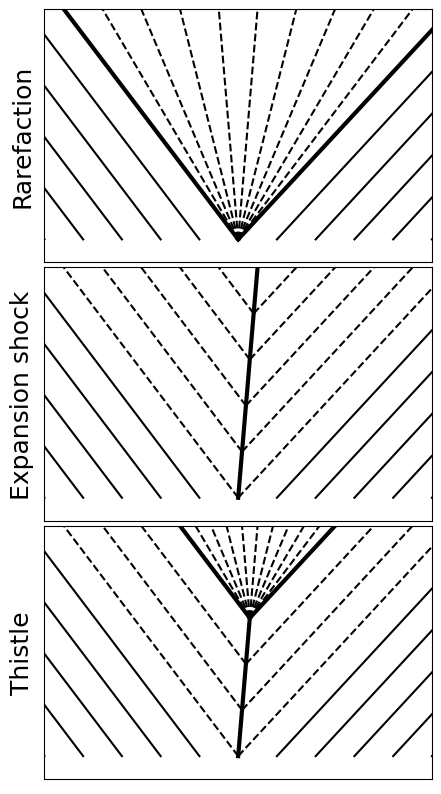

In [30]:
fig, axes = pyplot.subplots(3, 1, figsize=(5,10), sharex=True, gridspec_kw={'hspace':0.02})

t = numpy.array([0, 1])
v_shock = 0.1

x0s = numpy.array([-2, -1.8, -1.6, -1.4, -1.2, -1, -0.8, -0.6, -0.4, -0.2,
                    2,  1.8,  1.6,  1.4,  1.2,  1,  0.8,  0.6,  0.4,  0.2])
vl = v_shock - 1.
vr = v_shock + 1.
axes[0].plot(vl*t, t, 'k-', lw=3)
axes[0].plot(vr*t, t, 'k-', lw=3)
for x0 in x0s:
    if x0 < 0:
        v = vl
    else:
        v = vr
    axes[0].plot(x0+v*t, t, 'k-')
for v in numpy.linspace(vl, vr, 11):
    axes[0].plot(v*t, t, 'k--')
axes[0].set_ylabel('Rarefaction')
    
axes[1].plot(v_shock*t, t, 'k-', lw=3)
for x0 in x0s:
    if x0 < 0:
        v = vl
    else:
        v = vr
    axes[1].plot(x0+v*t, t, 'k-')
for t0 in numpy.linspace(0, 1, 6):
    ts = [t0, 1]
    axes[1].plot(v_shock * t0 + vl * (ts-t0), ts, 'k--')
    axes[1].plot(v_shock * t0 + vr * (ts-t0), ts, 'k--')
axes[1].set_ylabel('Expansion shock')

t_change = 0.6
t_c = numpy.array([0, t_change])
axes[2].plot(v_shock*t_c, t_c, 'k-', lw=3)
for x0 in x0s:
    if x0 < 0:
        v = vl
    else:
        v = vr
    axes[2].plot(x0+v*t, t, 'k-')
for t0 in numpy.linspace(0, t_change, 4):
    ts = [t0, 1]
    axes[2].plot(v_shock * t0 + vl * (ts-t0), ts, 'k--')
    axes[2].plot(v_shock * t0 + vr * (ts-t0), ts, 'k--')
t_raref = numpy.array([t_change, 1])
axes[2].plot(v_shock * t0 + vl * (t_raref - t0), t_raref, 'k-', lw=3)
axes[2].plot(v_shock * t0 + vr * (t_raref - t0), t_raref, 'k-', lw=3)
for v in numpy.linspace(vl, vr, 11):
    axes[2].plot(v_shock * t0 + v * (t_raref - t0), t_raref, 'k--')
axes[2].set_ylabel('Thistle')

for ax in axes.flatten():
    ax.set_xlim(-1, 1)
    ax.set_ylim(-0.1, 1)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    
fig.savefig('entropy_violation1.svg', bbox_inches='tight')